# Week 5 Part 2 Assignment
### DATA 620

David Moste ~ Euclid zhang ~ Samuel Reeves
***
### Problem Description

Can we make a model with Python's Natural Language Toolkit that accurately categorizes real and fake news?

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold

from bs4 import BeautifulSoup

import wordcloud
from wordcloud import WordCloud

### Data Description & Preprocessing
***
Data source: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

This set contains just under 50k news items, about 55:45 fake:real.  We have downloaded the set and put in the github repository zipped.  Unzip it and we can begin...

The important steps to transform this human-readable news into clean data are the following:

1. tokenizing the text bounded by whitespace
2. removing numbers and special characters (except the period used for abbreviations)
3. removing hyperlinks and artifacts of html
4. removing stop words
5. changing contractions to their long form (eg. he's --> he is)
6. The string "Images." at the end of the text, used to show that there are attached images
7. stemming and lemmatizing

In [2]:
fake_news = pd.read_csv(r"Fake.csv", header=0, index_col=False)
real_news = pd.read_csv(r"True.csv", header=0, index_col=False)

fake_news['fake'] = True
real_news['fake'] = False

fake_news.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",True
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",True
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",True
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",True
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",True


In [3]:
len(fake_news), len(real_news)

(23481, 21417)

There are too many news items! Training this model, even without cross-validation, crashes our machines.

![Crash](crash.png "Crash")

We subset the news items for the type 'politics' and with Trump mentioned somewhere.

In [4]:
fake_news2 = fake_news.loc[fake_news['subject'] == 'politics']
real_news2 = real_news.loc[fake_news['subject'] == 'politics']

fake_news2 = fake_news2.loc[[bool(re.search('[t|T]rump',news)) for news in fake_news2['text']]]
real_news2 = real_news2.loc[[bool(re.search('[t|T]rump',news)) for news in real_news2['text']]]

news = fake_news2[['text','fake']].append(real_news2[['text','fake']], ignore_index = True)

fake_news['text'][0]

'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t ev

Create stemmer and lemmatizer. Generate a list of stop words

In [5]:
porter = nltk.PorterStemmer()
wnl = nltk.WordNetLemmatizer()
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words = stop_words + ['could', 'should','would','']
stop_words.remove('not')

def clean_text(text):
    text = str(text).lower()   
    
    # Remove hyperlinks
    text = re.sub(r'[^\s]+\.com.[^\s]+','',text)
    text = re.sub(r'http[^\s]+','',text)
    
    # Clean the html tags
    text = BeautifulSoup(text).get_text()
    
    # A lot of the news items have the word 'images' at the end to represent that 
    # there are images attached to the news.
    text = re.sub(r'Images\.$', '', text)
    
    # Remove special characters except '.', since it can be used in abbreviations
    text = re.sub(r'[^A-Za-z\s\.]+', ' ', text)  
    # Remove '.' that is not used in abbreviations
    text = re.sub(r'([A-Za-z]{2,})\.', r'\1 ', text)
    
    # Replace multiple spaces by 1 space
    text = re.sub(r'\s{2,}', ' ', text)
       
    # In the text, the ' character is omiited. Therefore, string such as he's is stored as he s
    # The following code coverts such string to its complete form.
    # For example, he'll is coverted into he will
    text = re.sub(r'(he|she|it|this|that) (s )', r'\1 is', text)
    text = re.sub(r'(they|we) (re)', r'\1 are', text)
    text = re.sub(' ve ', ' have ', text)
    text = re.sub(' ll ', ' will ', text)
    text = re.sub('won t ', 'will not ', text)
    text = re.sub('n t ', ' not ', text)
    
    # Stopwords, stemming, lemmatizing
    text = [word for word in text.split(' ') if word not in stop_words]
    text = [porter.stem(word) for word in text]
    text = [wnl.lemmatize(word) for word in text]

    text = " ".join(text)
    text = text.strip()
    
    return text

nltk.download('wordnet')
news['cleaned_text'] = news['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /home/s/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/s/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Documents with only a hyperlink as content will become an empty string after clean up.  We can remove these.

In [7]:
news.loc[[len(news) == 0 for news in news['cleaned_text']]]['text']
news = news.loc[[len(news) != 0 for news in news['cleaned_text']]]
news.reset_index(drop=True, inplace = True)

In [8]:
news

,text,fake,cleaned_text
0,Just one more reminder of why President Trump ...,True,one remind presid trump chose nonsens gener jo...
1,Thank goodnesss Jeff Sessions is moving on fin...,True,thank goodness jeff session move find went beh...
2,The GOP presidential candidate who couldn t se...,True,gop presidenti candid not seem find spine perf...
3,John Podesta is Hillary Clinton s former campa...,True,john podesta hillari clinton former campaign c...
4,EAG News A Wyoming high school is under fire ...,True,eag news wyom high school fire parent expo onl...
...,...,...,...
4720,SEOUL (Reuters) - North Korea may be planning ...,False,seoul reuter north korea may plan new missil t...
4721,SEOUL/BEIJING (Reuters) - Chinese President Xi...,False,seoul beij reuter chine presid xi jinp repli n...
4722,(Reuters) - The White House admonished Russia ...,False,reuter white hous admonish russia wednesday ve...
4723,HONG KONG (Reuters) - Hong Kong will try to en...,False,hong kong reuter hong kong tri enact law penal...


## Analysis
***
Use TfidfVectorizer to calculate the Term Frequency — Inverse Document Frequency of unigram tokens.  This is equivalent to running CountVectorizer followed by TfidfTransformer.  With this *extremely* sparse matrix, we are taking a bag-of-words approach to describing each document.  We can then use these vectors to train our model using a Naive Bayes Classifier.

In [21]:
Tf_Idf_Vectorizer = TfidfVectorizer(ngram_range=(1,1))

X = Tf_Idf_Vectorizer.fit_transform(news['cleaned_text']).toarray()
Y = news['fake']

df_tfidfvect = pd.DataFrame(data = X,columns = Tf_Idf_Vectorizer.get_feature_names())

df_tfidfvect

,aaa,aadl,aapl,aardvark,aarhu,aaron,aaronapollocamp,aarondfordnv,aarp,ab,...,ztqxcz,zucker,zuckerberg,zuckerman,zuckersaid,zuhri,zullo,zuma,zwgrt,zyuganov
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_tfidfvect_real = df_tfidfvect.loc[news['fake'] == False]
df_tfidfvect_fake = df_tfidfvect.loc[news['fake']]

The most important key words mentioned in real news are:

In [11]:
most_important_real = df_tfidfvect_real.sum().sort_values(ascending = False).T
most_important_real[:20]

said           129.016760
trump          101.840532
republican      78.017812
state           68.189751
reuter          63.491731
not             53.544606
jerusalem       51.355068
korea           47.992599
cruz            47.583278
presid          47.443433
north           46.503688
unit            45.999406
presidenti      45.874973
israel          45.858149
parti           44.132577
clinton         40.902743
campaign        39.055905
candid          37.588130
palestinian     37.382781
nomin           36.821695
dtype: float64

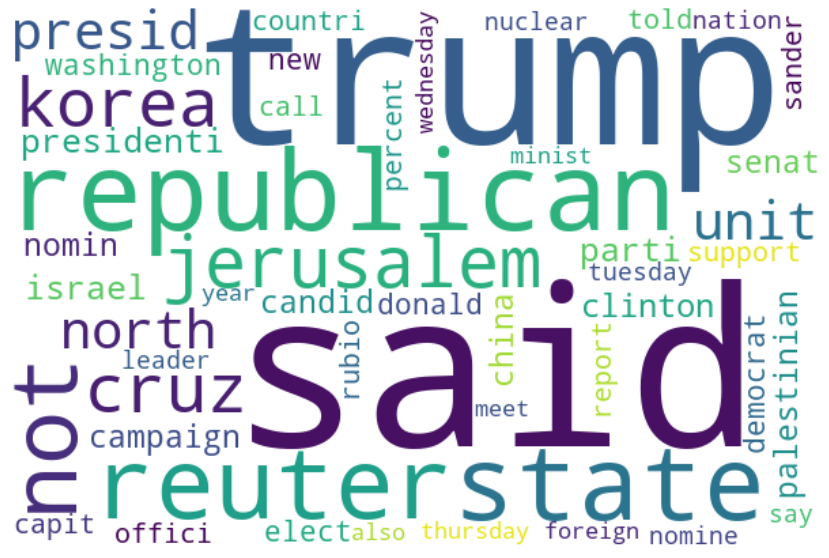

In [12]:
Cloud = WordCloud(width=600, height=400, background_color="white", max_words=50).generate_from_frequencies(most_important_real)
plt.figure(figsize = (15,10))
plt.imshow(Cloud, interpolation ='bilinear')
plt.axis('off')
plt.show()

The most important key words mentioned in fake news are:

In [13]:
most_important_fake = df_tfidfvect_fake.sum().sort_values(ascending = False).T
most_important_fake[:20]

trump       169.729204
not         123.638472
presid       89.359200
clinton      69.766304
said         69.504908
hillari      64.867057
obama        64.548276
peopl        57.010919
american     51.366675
donald       50.776834
support      49.894581
one          48.224207
say          47.568663
democrat     47.076994
news         46.442399
like         46.320346
elect        44.539405
go           44.444287
state        43.346123
report       43.193090
dtype: float64

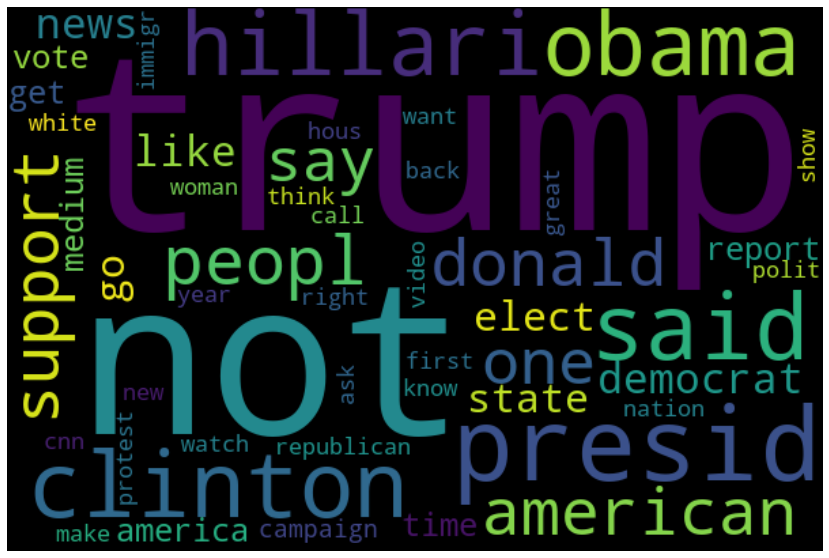

In [14]:
Cloud = WordCloud(width=600, height=400, background_color="black", max_words=50).generate_from_frequencies(most_important_fake)
plt.figure(figsize = (15,10))
plt.imshow(Cloud, interpolation ='bilinear')
plt.axis('off')
plt.show()

It's interesting to see that a lot of key words about real news are about republicans and a lot of key words about fake news are democrats. We suppose that this is because of the subsetting.  Perhaps the opposite would occur if we chose only those news stories with the subject politics and subsetted by the word "Clinton".  It's also interesting to note that "Reuters" is a notably common word in the real news.

Now let's build our model using Multinomial Naive Bayes.

In [18]:
mnb = MultinomialNB()

model_scores = pd.DataFrame(columns = ['accurary','precision','recall','F1',
                                       'True Positive','False Positive','True Negative','False Negative'])
kf = KFold(n_splits=5,random_state=620,shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    mnb.fit(X_train, Y_train)
    y_pred = mnb.predict(X_test)
    accuracy = metrics.accuracy_score(Y_test, y_pred)
    precision = metrics.precision_score(Y_test, y_pred)
    recall = metrics.recall_score(Y_test, y_pred)
    F1 = metrics.f1_score(Y_test, y_pred)
    cm = metrics.confusion_matrix(Y_test, y_pred)
    cm = cm/cm.astype(float).sum(axis=0)
    model_scores.loc[len(model_scores)] = [accuracy,precision,recall,F1,cm[1, 1],cm[0, 1],cm[0, 0],cm[1, 0]]
    
model_scores.loc['Average'] = model_scores.mean()
model_scores

,accurary,precision,recall,F1,True Positive,False Positive,True Negative,False Negative
0,0.896296,0.870185,0.988655,0.925645,0.870185,0.129815,0.971311,0.028689
1,0.881481,0.851095,0.983137,0.912363,0.851095,0.148905,0.961538,0.038462
2,0.918519,0.895678,0.988487,0.939797,0.895678,0.104322,0.974453,0.025547
3,0.876190,0.849083,0.983660,0.911431,0.849083,0.150917,0.957627,0.042373
4,0.904762,0.895415,0.973520,0.932836,0.895415,0.104585,0.931174,0.068826
Average,0.895450,0.872291,0.983492,0.924414,0.872291,0.127709,0.959221,0.040779
6,0.896296,0.870185,0.988655,0.925645,0.870185,0.129815,0.971311,0.028689
7,0.881481,0.851095,0.983137,0.912363,0.851095,0.148905,0.961538,0.038462
8,0.918519,0.895678,0.988487,0.939797,0.895678,0.104322,0.974453,0.025547
9,0.876190,0.849083,0.983660,0.911431,0.849083,0.150917,0.957627,0.042373


### Scoring
***
The scores indicate that our model is performing well! The accurary is around 90 percent. We have correctly identified 87% of the fake news and 96% of the real news after subsetting for politics and Trump.